# Basics of DJUICE: A square ice shelf

This tutorial demonstrates how to compute the velocity field of a steady-state square ice shelf using the Differentiable Julia ICE (DJUICE) model. We follow the approach outlined in the Ice-sheet and Sea-level System Model (ISSM) tutorial, adapted from its original C++ implementation to Julia. The original ISSM tutorial can be found [here](https://issm.jpl.nasa.gov/documentation/tutorials/squareiceshelf/).

## Install the package

To follow this tutorial, you need to install the [`DJUICE`](https://github.com/DJ4Earth/DJUICE.jl) package. DJUICE is available on Julia package registry, and you can install it directly from the repository.

### Option 1: Using the Julia Package Manager
1. Open your Julia REPL.
2. Enter the package manager mode by pressing `]`.
3. Run the following command to add DJUICE from the main branch of the repository:
```julia
]add DJUICE#main
```

### Option 2: Using `Pkg` 
Use `Pkg` to instantiate the environment and install the dependencies in `Project.toml` from the mini-tutorial.

## Initialize the model

All the data belonging to a model (geometry, node coordinates, results, etc.) is held in the single object `Model`. This will create a new model named `md` whose `struct` is `DJUICE.Model`. The information contained in the model `md` is grouped by `struct`, that contain fields related to a particular aspect of the model (e.g. mesh, ice geometry, material properties, friction, stressbalance solution, results of the runs, etc.). When one creates a new model, all these fields are initialized, and ready to be used as a `DJUICE` model. 

To create a new model, use the following command. This command initializes the `md` object, setting up the model structure with all necessary fields.


In [1]:
using DJUICE

md = model()

Model:


               mesh: DJUICE.Mesh2dTriangle      -- mesh properties
           geometry: DJUICE.Geometry            -- surface elevation, bedrock topography, ice thickness,...
               mask: DJUICE.Mask                -- defines grounded and floating regions
          materials: DJUICE.Materials           -- material properties
     initialization: DJUICE.Initialization      -- initial state
          constants: DJUICE.Constants           -- physical constants
           friction: DJUICE.BuddFriction        -- basal friction
      basalforcings: DJUICE.Basalforcings       -- basal forcings
                smb: DJUICE.SMBforcings         -- surface mass balance
       timestepping: DJUICE.Timestepping        -- time stepping for transient simulations
      stressbalance: DJUICE.Stressbalance       -- parameters stress balance simulations
      masstransport: DJUICE.Masstransport       -- parameters mass transport simulations
          transient: DJUICE.Transient           -- parame

## Generate Mesh

(https://en.wikipedia.org/wiki/International_System_of_Units) unit system.

Then, we set the whole domain to be ice-covered, as an ice shelf.


To generate a triangular mesh, you need:
- a domain outline defined by `domainname` (which is the name of an `exp` file, see below)
- define a characteristic element length `resolution`
```julia
md=triangle(md, domainname, resolution)
```

We start with a square domain of $[0, 10^6~\text{m}]\times[0,10^6~\text{m}]$ with $5\times10^3$~m mesh resolution. We then set the mask as fully floating.

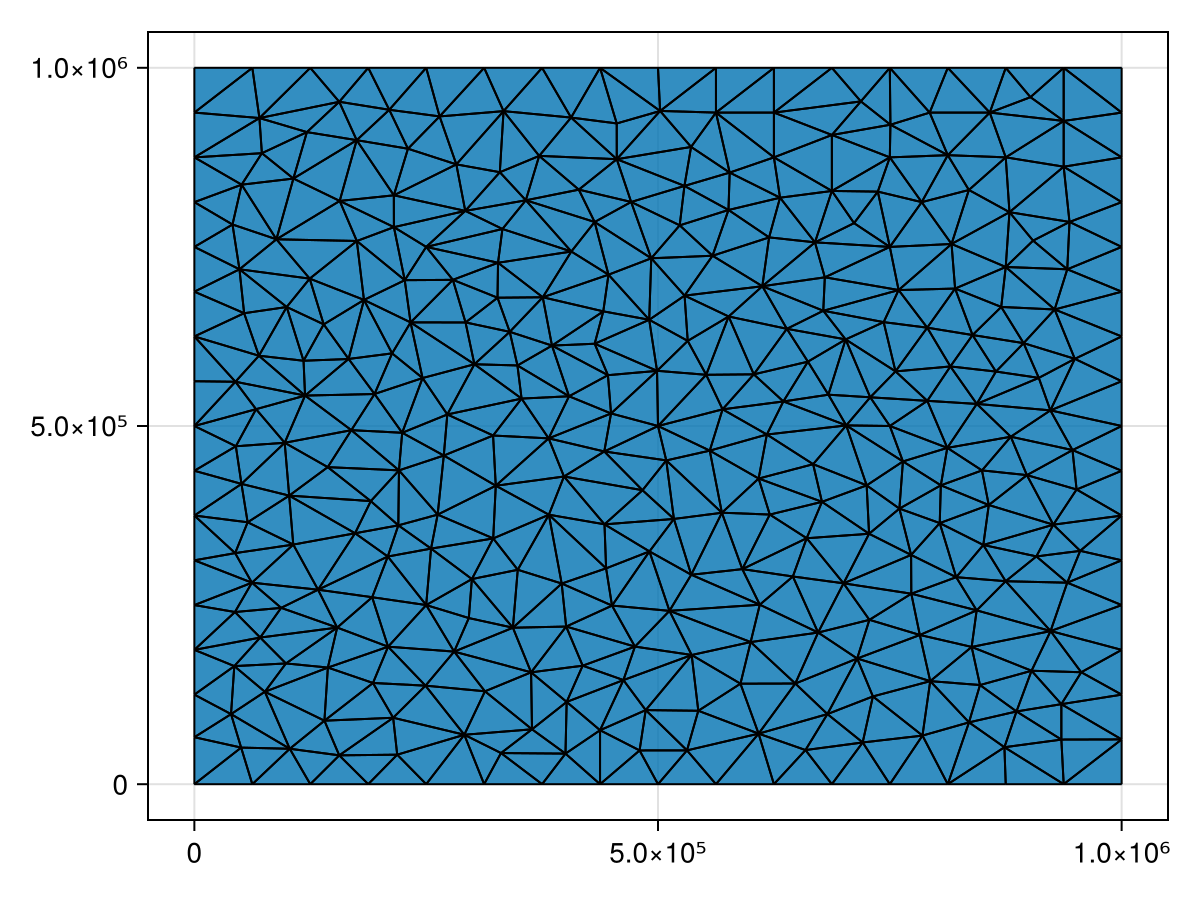

In [2]:
#Create a new mesh for a square domain, with a resolution of 50 km
md = triangle(md, issmdir()*"/test/Exp/Square.exp", 50000.) 

#Set the mask as fully floating
md = setmask(md,"all","")

#Show mesh
using CairoMakie
plotmodel(md, "mesh")

## Set the geometry

We define the ice geometry on the given domain. 

### Ice thickness
Let's set the `thickness` of the ice shelf to be 
$$H(x,y)=h_{\max} + \frac{h_{\min}-h_{\max}}{L_y}y$$
where $h_\min=300$ m and $h_\max=1000$ m

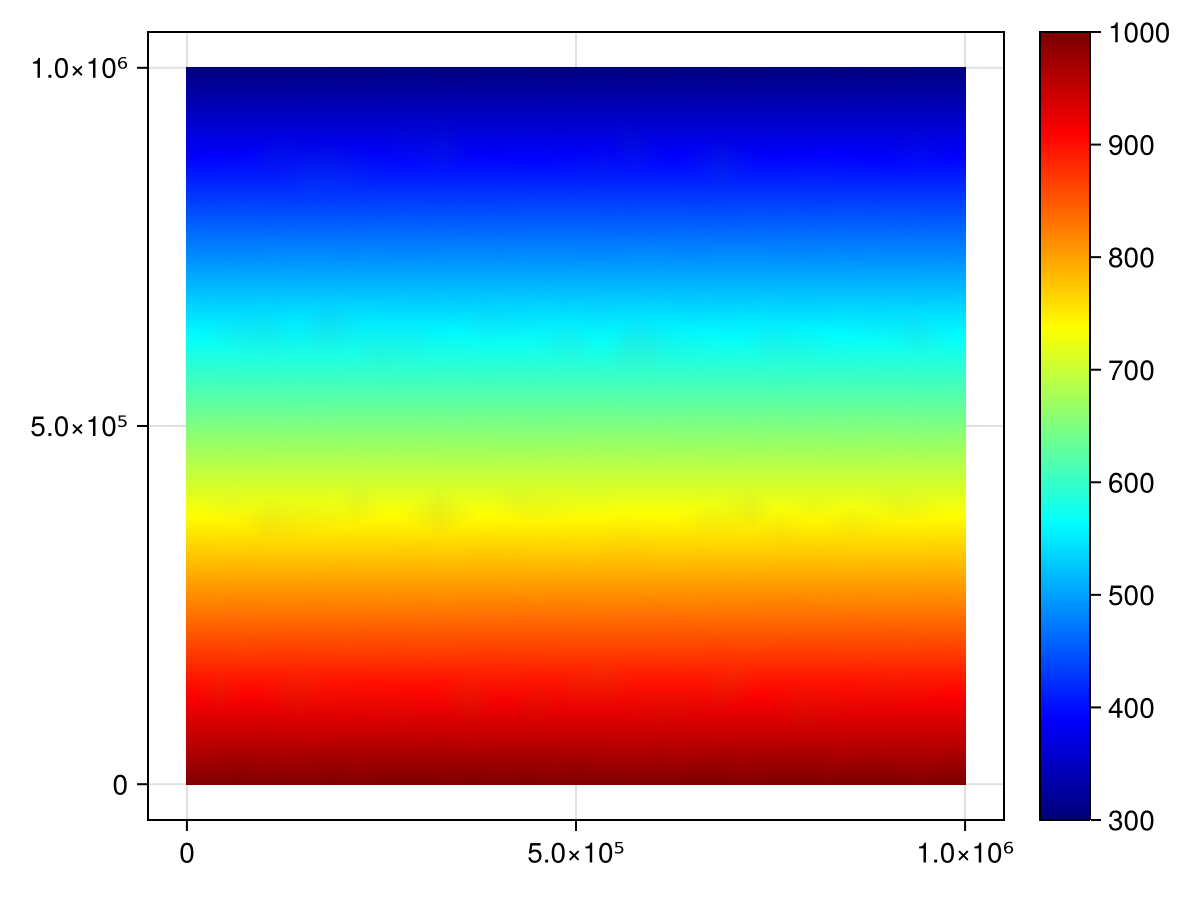

In [3]:
hmin = 300.
hmax = 1000.
ymin = minimum(md.mesh.y)
ymax = maximum(md.mesh.y)
	
md.geometry.thickness = hmax .+ (hmin-hmax)*(md.mesh.y .- ymin)./(ymax-ymin)

# plot the ice thickness
plotmodel(md, md.geometry.thickness)

### Ice base
Because the ice shelf is floating and in hydrostatic equilibrium, we can determine the `base` of the ice by:
$$b=-\frac{\rho_i}{\rho_w}\times H,$$where $\rho_i$ and $\rho_w$ are the density of ice and water. The physical constants are given by default in `md.materials` when initialize the model.

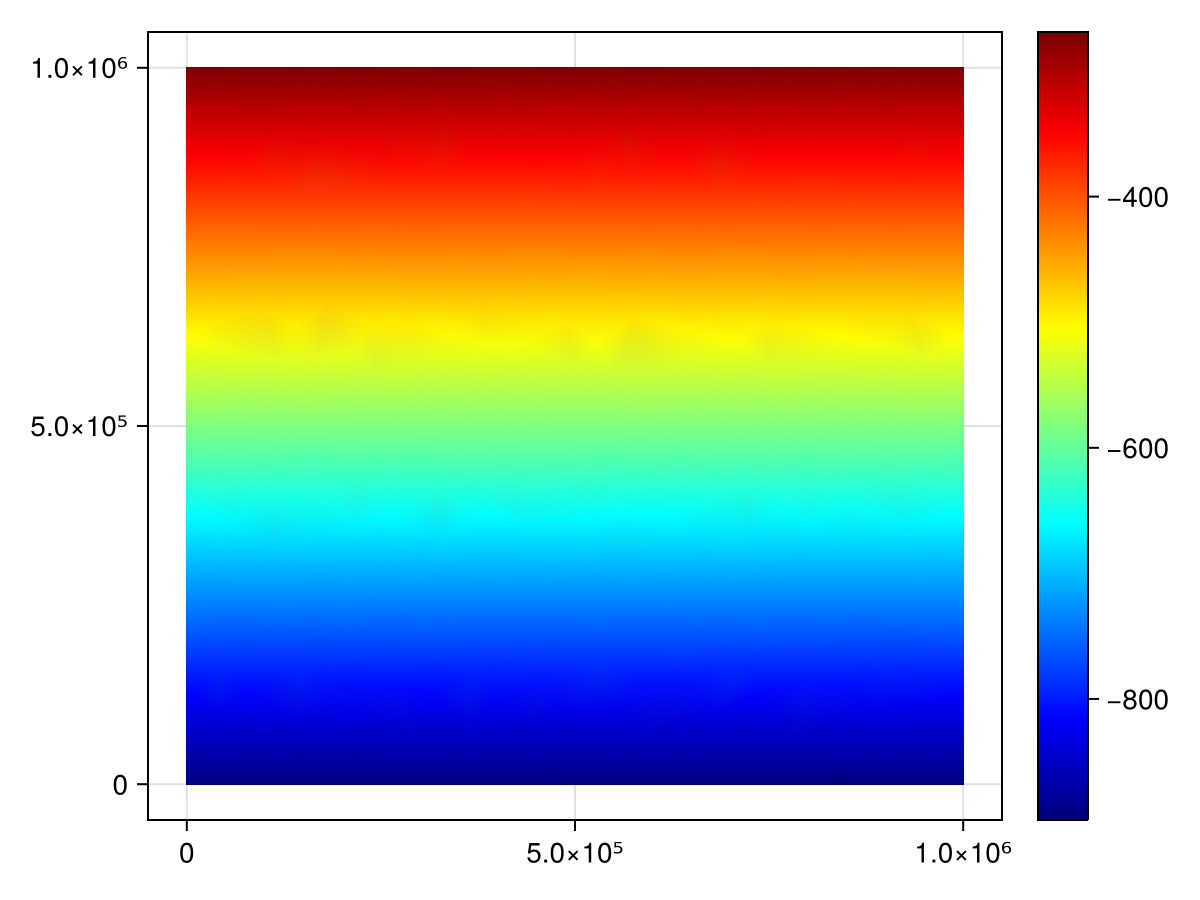

In [4]:
md.geometry.base = -md.materials.rho_ice/md.materials.rho_water*md.geometry.thickness
plotmodel(md, md.geometry.base)

### Ice surface

The `surface` of the ice is then calculated as $s=b+H$.

In [5]:
md.geometry.surface   = md.geometry.base+md.geometry.thickness;

In this tutorial, we are going to work on an ice shelf. To gurantee the ice is completely floating, we set the ocean bathymetry `bed` (bedrock) elevation to be 10 meters deeper than the `base` of the ice:

In [6]:
md.geometry.bed = md.geometry.base .-10;

## Set intitial conditions

Ice is a non-Newtonian fluid and we need to define an initial velocity to solve a stress balance. Here, to keep things simple, we set the initial velocity to zeros:

In [7]:
# set initial velocity 
md.initialization.vx = zeros(md.mesh.numberofvertices);
md.initialization.vy = zeros(md.mesh.numberofvertices);

## Set physical parameters

Ice behaves as a viscous fluid. Its governing dynamics are described by the Shelfy Stream Approximation (SSA), expressed as a system of PDEs: 

$$\nabla\cdot\boldsymbol{\sigma}+{\boldsymbol{\tau}}_b=\rho_i g H \nabla s$$
where $\boldsymbol{\tau}_b=(\tau_{bx}, \tau_{by})^T$ represents the basal shear stress, $\rho_i$ is the ice density, $g$ is the gravitational acceleration. $\boldsymbol{\sigma}$ is the stress tensor of the SSA model defined as

$$\boldsymbol{\sigma} = \mu H
    \begin{bmatrix}
         \displaystyle 4\frac{\partial u}{\partial x}+2\frac{\partial v}{\partial y} 
         & 
         \displaystyle \frac{\partial u}{\partial y}+\frac{\partial v}{\partial x}  \\
         \\
         \displaystyle \frac{\partial u}{\partial y}+\frac{\partial v}{\partial x} 
         &
         \displaystyle 2\frac{\partial u}{\partial x}+4\frac{\partial v}{\partial y}
    \end{bmatrix}.$$

The ice viscosity, $\mu$, is determined by Glen's flow law, which in two dimensions reads: 

$$\mu =\frac{B}{2}\left( \left(\frac{\partial u}{\partial x}\right)^2 + \left(\frac{\partial v}{\partial y}\right)^2 + \frac{1}{4}\left(\frac{\partial u}{\partial y} +\frac{\partial v}{\partial x}\right)^2 + \frac{\partial u}{\partial x}\frac{\partial v}{\partial y}\right)^{\frac{1-n}{2n}},$$

where $n = 3$ is the flow-law exponent, and $B$ is the pre-factor that depends on ice temperature, among other factors. 


The above PDEs is what `DJUICE` is going to solve. We will only need to set the pre-factor $B$ and exponent $n$ in this tutorial.

In [8]:
md.materials.rheology_B = 1.815730284801701e+08*ones(md.mesh.numberofvertices)
md.materials.rheology_n = 3*ones(md.mesh.numberofelements);

The basal shear stress is related to the ice velocity by a friciton law, here we use the Budd friction law

$$\tau_b=C^2N^\frac{q}{p}|u_b|^{\frac{1}{q}-1}u_b$$

where the effective pressure $N$ is calculated by `DJUICE` at the base of the ice (note that basal friction is not applied here since the ice is floating!).

To start, we set the basal friction coefficient $C=20~\text{m}^{-1/2} \text{s}^{1/2}$, and the exponents $p=1$ and $q=1$.

In [9]:
md.friction.coefficient = 20*ones(md.mesh.numberofvertices)
md.friction.p = ones(md.mesh.numberofvertices)
md.friction.q = ones(md.mesh.numberofvertices);

## Boundary conditions

Let's set the left, bottom, right boundaries to be Dirichlet boundary, and the top boundary to be a calving front boundary. In `DJUICE`, the calving front boundary is automatically determined by the 0-levelset contour of `md.mask.ice_levelset`.

The Dirichlet boundaries are the rest of the boundaries of the domain, by setting the values in `md.stressbalance.spcvx` and `md.stressbalance.spcvy`.

In [10]:
#Boundary conditions

#ice front at y=ymax
pos = findall(md.mesh.vertexonboundary .& (md.mesh.y.==ymax))
md.mask.ice_levelset[pos] .= 0

#Homogeneous Dirichlet conditions along the other boundaries
md.stressbalance.spcvx = NaN*ones(md.mesh.numberofvertices)
md.stressbalance.spcvy = NaN*ones(md.mesh.numberofvertices)
pos = findall(md.mesh.vertexonboundary .& (md.mesh.y.<ymax))
md.stressbalance.spcvx[pos] .= 0.0;
md.stressbalance.spcvy[pos] .= 0.0;

## Numerical tolerance

- `restol` is the mechanical equilibrium residual convergence criterion
- `reltol` is the velocity relative convergence criterion
- `abstol` is the velocity absolute convergence criterion

If the tolerance is set to `NaN`, that means it is not applied.

In [11]:
md.stressbalance.restol=0.05
md.stressbalance.reltol=0.05
md.stressbalance.abstol=NaN;

## Solve

Now let's solve the nonlinar PDEs. `DJUICE` uses a fixed point (Picard) method:

In [12]:
md=solve(md,:Stressbalance);

   creating datasets for analysis DJUICE.StressbalanceAnalysis
      detecting active vertices
   computing stress balance
   Renumbering degrees of freedom
   Allocating matrices
   Assembling matrices
   Solving matrix system
   checking convergence
   mechanical equilibrium convergence criterion 100.0 > 5.0 %
   Convergence criterion: norm(du)/norm(u)      Inf > 5.0 %
   Allocating matrices
   Assembling matrices
   Solving matrix system
   checking convergence
   mechanical equilibrium convergence criterion 63.42920092609031 > 5.0 %
   Convergence criterion: norm(du)/norm(u)      34.19076451461998 > 5.0 %
   Allocating matrices
   Assembling matrices
   Solving matrix system
   checking convergence
   mechanical equilibrium convergence criterion 32.789287440947405 > 5.0 %
   Convergence criterion: norm(du)/norm(u)      23.896733858723728 > 5.0 %
   Allocating matrices
   Assembling matrices
   Solving matrix system
   checking convergence
   mechanical equilibrium convergence crite

## plot solutions

The solutions are in `md.results["StressbalanceSolution"]`. We can plot the velocity magnitude by the following command.

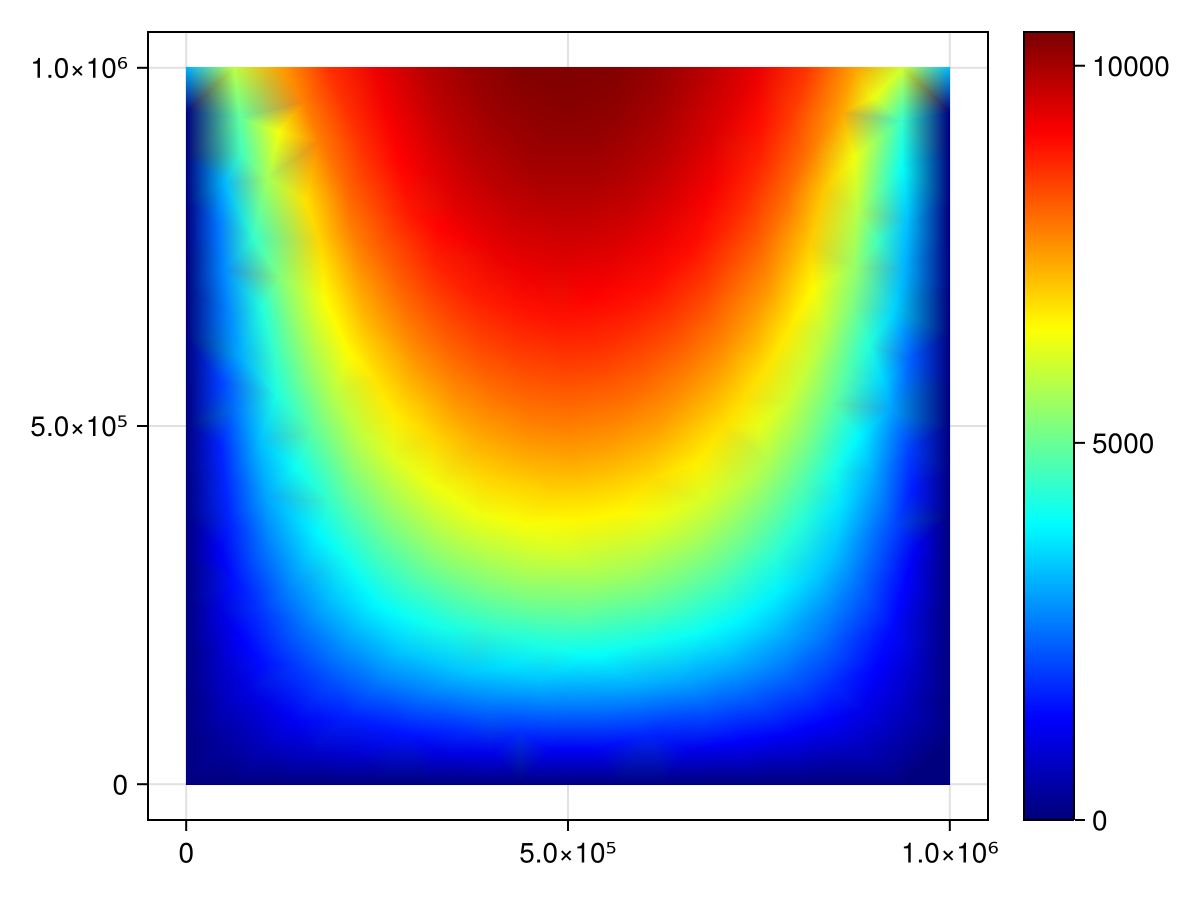

In [13]:
plotmodel(md, md.results["StressbalanceSolution"]["Vel"])